# Estimating Pi

The following example should highlight, how one can convert most Python classes that take arguments into a PyTrack class.
Here we take on an example to Estimate the value Pi.
The original notebook can be found here https://gist.github.com/SamTov/907aebbc6c36a242e15e3745a91989eb .
There were only a few changes made:

    1. convert parameters to `DVC.params()`
    2. convert restuls to `DVC.result()`
    3. Add a `__call__` method for the adding the parameters to the class
    4. Add a `run` method that does the heavy lifting for us and runs the expensive computation
    5. Make the results json serializeable, which in this case means we need to convert them to a list (as an alternative we could save them as a numpy file, if they are to large)

That's it - now we can use the `@PyTrack()` decorator and we can even stay inside the Jupyter notebook.

In [1]:
# We are working in a temporary directory for easier cleanup
import os
import shutil
from tempfile import TemporaryDirectory
from pytrack import PyTrackProject

temp_dir = TemporaryDirectory()
cwd = os.getcwd()

shutil.copy("estimate_pi_with_mc.ipynb", temp_dir.name)

os.chdir(temp_dir.name)

project = PyTrackProject()
project.create_dvc_repository()

In [2]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
from pytrack import PyTrack, DVC
matplotlib.rcParams.update({'errorbar.capsize': 4})

In [3]:
@PyTrack(nb_name="estimate_pi_with_mc.ipynb")
class MCPi:
    """
    A class to study Monte Carlo sampling as applied to
    the computation of Pi.

    Attributes
    ----------
    coordinates : np.ndarray
            Coordinates of points plotted.
    n_circle_points : int
            Number of points in the circle
    n_points : int
            Total number of points.
    """

    def __init__(self):
        """
        Constructor for the MCPi class.
        """
        self.coordinates = DVC.result()
        self.n_circle_points = DVC.result()
        self.n_points = DVC.params()

    def plot_image(self, axs = None):
        """
        Plot the circle, square, and points.

        Parameters
        ----------
        axs : mpl.axis
                An axis object to plot to if desired.
        """
        circle = plt.Circle((0, 0), 1, fill=False)
        square = patches.Rectangle((0, 0), 1, 1, fill=False)
        if axs is None:
            ax = plt.gca()
        else:
            ax = axs
        ax.set_xlim(-1.3, 1.3)
        ax.set_ylim(-1.3, 1.3)
        ax.spines.left.set_position('zero')
        ax.spines.right.set_color('none')
        ax.spines.bottom.set_position('zero')
        ax.spines.top.set_color('none')
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        ax.add_patch(circle)
        ax.add_patch(square)
        ax.set_aspect('equal')
        plt.show()

    def plot_sampling(self, axs = None, show: bool = False):
        """
        Plot the result of the sampling.

        Parameters
        ----------
        axs : mpl.axis
                An axis object to plot to if desired.
        """
        coordinates = np.array(self.coordinates)
        circle = plt.Circle((0, 0), 1, fill=False, linewidth=3, edgecolor='k', zorder=10)
        square = patches.Rectangle((0, 0), 1, 1, fill=False, linewidth=3, edgecolor='k', zorder=10)
        if axs is None:
            ax = plt.gca()
        else:
            ax = axs
        ax.set_xlim(-0.0, 1.0)
        ax.set_ylim(-0.0, 1.0)
        ax.spines.left.set_position('zero')
        ax.spines.right.set_color('none')
        ax.spines.bottom.set_position('zero')
        ax.spines.top.set_color('none')
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        ax.plot(coordinates[:, 0], coordinates[:, 1], '.')
        inner_points = np.array(list(filter(lambda x: np.linalg.norm(x) <= 1, coordinates)))
        ax.plot(inner_points[:, 0], inner_points[:, 1], 'r.')
        ax.add_patch(circle)
        ax.add_patch(square)
        ax.set_title(f"N: {self.n_points} ; $\pi$ = {4 * self.n_circle_points / self.n_points}")
        ax.set_aspect('equal')

        if show:
            plt.show()

    def _circle_points(self):
        """
        Compute the number of points in the circle.
        """
        radial_values = np.linalg.norm(self.coordinates, axis=1)
        self.n_circle_points = len(list(filter(lambda x: x <= 1, radial_values)))

    def __call__(self, n_points):
        self.n_points = n_points

    def run(self):
        """
        Draw N points from a normal distribution.

        N : int
                Number of points to draw.
        """
        self.coordinates = np.random.random(size=(self.n_points, 2)).tolist()
        self._circle_points()  # compute the number of points in the circle.

Jupyter support is an experimental feature! Please save your notebook before running this command!
Submit issues to https://github.com/zincware/py-track.


Now let us define pi estimates with different numbers of points and run them all.

In [4]:
mc_study = MCPi()
mc_study(n_points=10000)
project.name="n=10000"
project.queue()

mc_study = MCPi()
mc_study(n_points=1000)
project.name="n=1000"
project.queue()

mc_study = MCPi()
mc_study(n_points=100)
project.name="n=100"
project.run()

Updating coordinates with PyTrackOption and value None!
Updating n_circle_points with PyTrackOption and value None!
Updating n_points with PyTrackOption and value None!
Updating n_points with 10000
No results found!
'DVCParams' object has no attribute 'result'
No results found!
'DVCParams' object has no attribute 'result'
'DVCParams' object has no attribute 'params'
--- Writing new DVC file! ---
Overwriting existing configuration!
running script: dvc run -n MCPi_0 --outs outs\0_MCPi.json --params config\pytrack.json:MCPi.0.params --deps src\MCPi.py --force --no-exec python -c "from src.MCPi import MCPi; MCPi(id_=0).run()"
Updating coordinates with Descriptor for result
Result can only be changed within `run` call!
Updating n_circle_points with Descriptor for result
Result can only be changed within `run` call!
Updating n_points with Descriptor for params
Updating n_points with 1000
No results found!
'DVCParams' object has no attribute 'result'
No results found!
'DVCParams' object has n

We can now see our experiments and the respective hash values:


In [5]:
project.exp_dict

{'master': '19ea693ef750ccd2c4a96fa1e472b41150421cdc',
 'n=10000': 'cb603c6ae1adbd1e7afe5ef0bc4046d86b83ffb8',
 'n=1000': '4b607373b6abbe6f236e5fd8618ca7ae16d6abae',
 'n=100': 'a0ab48cafac1963053a0e09189c561bfcd45422f'}

Let us load them and plot them after each other. Because all the calculations where already performed, this is simply loading the correct result files.

Loading results {'coordinates': [[0.9534825030724863, 0.9736849411975227], [0.4931813940740759, 0.9829880634823199], [0.905733423691089, 0.08003728031596613], [0.6458820678585072, 0.8594859899943744], [0.1543061583646207, 0.3991143444118941], [0.8944992953214292, 0.7524198230690267], [0.3482861699497045, 0.1838983304913301], [0.3484124166686169, 0.22228920010969255], [0.8666813514949976, 0.3479442485755808], [0.5753924613900492, 0.48369122618736793], [0.3416939509578981, 0.7833704143111562], [0.7992174072370316, 0.9349655951431536], [0.5499628017442535, 0.9555993037176029], [0.19513334907248558, 0.781183165205529], [0.000191201202975666, 0.7974948754175745], [0.19048097679365183, 0.5142736769759063], [0.981139913053156, 0.8874601212132418], [0.8312099217972992, 0.3631622979645498], [0.26901852293646433, 0.6974588613431282], [0.13070999325288635, 0.23289296597494924], [0.5362344445301506, 0.5979895080388822], [0.03865489328276617, 0.969133111256937], [0.1296573955994711, 0.5776197742162

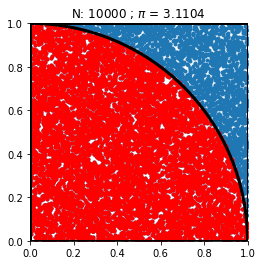

Loading results {'coordinates': [[0.13154137025394552, 0.9819474935820048], [0.7394497786836224, 0.14410115666416312], [0.7289775064128416, 0.9255991704994944], [0.15991470958178944, 0.0648327295056037], [0.200972710252323, 0.26734505545851994], [0.11264451625794658, 0.2575883945657069], [0.32997083466667043, 0.9110051822136703], [0.4450457686720788, 0.5246037391263892], [0.16146846244205848, 0.7079206854430556], [0.21945159723035135, 0.48334870914535655], [0.21931802498569308, 0.060281216676286276], [0.16037538947249075, 0.1837466775065274], [0.67031320257703, 0.4846253960716689], [0.3071718474559956, 0.37242654583886237], [0.7477245656692298, 0.9189489663795941], [0.49085999498887667, 0.6979861672514844], [0.2940636035325712, 0.6146227958479566], [0.9330540711393015, 0.9173243694790003], [0.9836303602047735, 0.5453440668663023], [0.06532730356038818, 0.7667895671856697], [0.957451450694035, 0.3270816264515338], [0.7067431517743173, 0.8606067643512108], [0.08250097304083037, 0.7691631

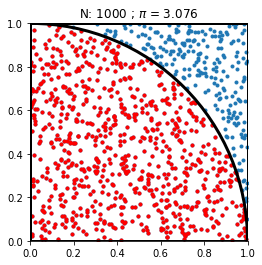

Loading results {'coordinates': [[0.8724415699724664, 0.6687925773724308], [0.7139529950836644, 0.5558872943960451], [0.9162203559816746, 0.810126905544009], [0.8473531644754981, 0.46131733138732567], [0.12510716676812927, 0.30529506566393416], [0.2576547151915758, 0.6343821274934224], [0.21505999185257374, 0.5435234712569175], [0.4068178860635181, 0.7028955091925485], [0.37846887026521425, 0.995082970870481], [0.5854972880240692, 0.7551726022535769], [0.8523183613857028, 0.8404803122246443], [0.7550216921139927, 0.3271379764725475], [0.4871324772244381, 0.9261672999894868], [0.846652513125822, 0.7447060798105404], [0.7094909718762383, 0.16996167251750816], [0.11225899975604992, 0.23617771144512567], [0.1063818978708907, 0.37272840260932816], [0.5286961574343874, 0.6146413105241002], [0.2698698342788467, 0.340030521265104], [0.9024651386911181, 0.23003239812434628], [0.23162147665868016, 0.9080007912119784], [0.9389403674333924, 0.10254030957738836], [0.7148899521590778, 0.095853283226

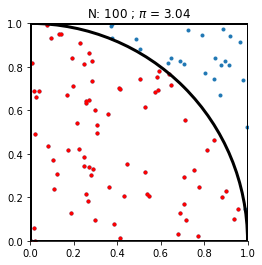

In [6]:
project.load("n=10000")
mc_study.plot_sampling(show=True)
project.load("n=1000")
mc_study.plot_sampling(show=True)
project.load("n=100")
mc_study.plot_sampling(show=True)

In [7]:
# Cleanup all files
os.chdir("..")
temp_dir.cleanup()